In [1]:
#analytics
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from entropy.entropy import *
import mass_ts as mts
import stumpy

# visuals
import matplotlib.pyplot as plt

/Users/tortysivill/.pyenv/versions/entropy_time/lib/python3.6/site-packages/mass_ts/_mass_ts.py:18: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  'GPU support will not work. You must pip install mass-ts[gpu].')


## Import Condition Data

In [2]:
path = "data/useful/depresjon/"

In [3]:
    
condition = [pd.read_csv(f,header=0, index_col=0, parse_dates=True, squeeze=True) for f in glob.glob(path + "data/condition/*.csv")]
control = [pd.read_csv(f,header=0, index_col=0, parse_dates=True, squeeze=True) for f in glob.glob(path + "data/control/*.csv")]

## Import Control Data

## Display Individual Condition

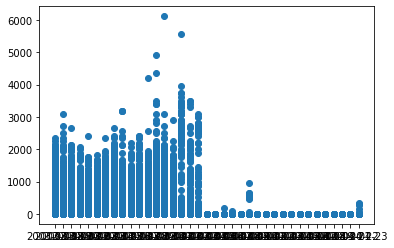

In [4]:
plt.scatter(control[0]['date'],control[0]['activity'])
plt.show()

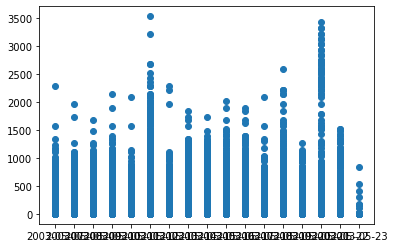

In [5]:
plt.scatter(condition[0]['date'],condition[0]['activity'])
plt.show()

## Histogram of Control and Condition Averages

In [6]:
control_mean = [np.mean(x) for x in control]
condition_mean = [np.mean(x) for x in condition]



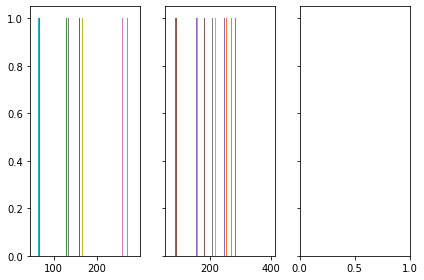

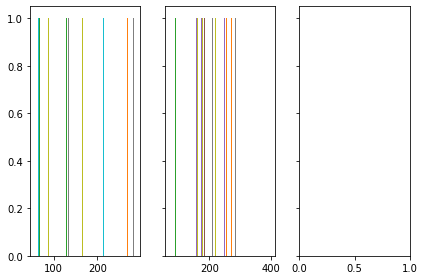

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg

axs[0].hist(condition_mean, bins=10)
axs[1].hist(control_mean, bins=10)

fig

## Extract Features

### Extracting the following features from selected data

<ol>
<li>Mean Activity Level</li>
<li>Standard Deviation</li>
<li> Trimmed Mean </li>
</ol>

In [8]:

# separate into condition and control lists
x = np.zeros(23)
y = np.ones(len(control))
index = np.hstack((x,y))
df_scores = pd.read_csv(path + 'data/scores.csv')
df_scores['group'] = index

split_scores_control = list(df_scores.groupby('group'))[1]
split_scores_condition = list(df_scores.groupby('group'))[0]

# Clean data to only include the first n days of data records
limited_control = [list(x.groupby('date'))[0:y] for x, y in zip(control,split_scores_control[1]['days'])]
limited_condition =[list(x.groupby('date'))[0:y] for x, y in zip(condition,split_scores_condition[1]['days'])]

untupled_list = []
for y in limited_control:
    untupled_list.append([x[1] for x in y])
limited_control_df = [pd.concat(x) for x in untupled_list]

untupled_list = []
for y in limited_condition:
    untupled_list.append([x[1] for x in y])
limited_condition_df = [pd.concat(x) for x in untupled_list]

In [9]:

training_data_raw = [x['activity'].values for x in limited_condition_df] + [x['activity'].values for x in limited_control_df]

In [10]:
def normalise(X):
    return [(x - min(X))/(max(X)-min(X)) for x in X]

In [11]:
from scipy.stats import trim_mean
    
df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

df_features['perm_entropy'] = normalise([perm_entropy(x,10) for x in training_data_raw])
df_features['sample_entropy'] = normalise([sample_entropy(x,2) for x in training_data_raw])
df_features['app_entropy'] = normalise([app_entropy(x,2) for x in training_data_raw])
df_features['svd_entropy'] = normalise([svd_entropy(x,3) for x in training_data_raw])
df_features['spectral_entropy'] = normalise([spectral_entropy(x,100) for x in training_data_raw])

In [12]:
feature_combinations = []

feature_names = ['perm', 'sample', 'app', 'svd','spectral']
# singles
feature_combinations.append(df_features.drop(['sample_entropy', 'app_entropy', 'svd_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'app_entropy', 'svd_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'svd_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'app_entropy', 'spectral_entropy'],axis=1).values)
feature_combinations.append(df_features.drop(['perm_entropy', 'sample_entropy', 'app_entropy', 'svd_entropy'],axis=1).values)




In [13]:
y = np.asarray([1 for x in range(0,len(condition))] + [0 for x in range(0,len(control))])


## Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
accuracy_scores = []
f1_scores = []

for X in feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=10, scoring='f1_weighted'))

In [15]:
print(np.mean(accuracy_scores,axis=1))


[0.73       0.72666667 0.74666667 0.65333333 0.76      ]


1: perm
2: sample
3: app
4: svd
5: spectral


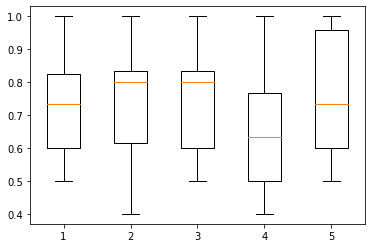

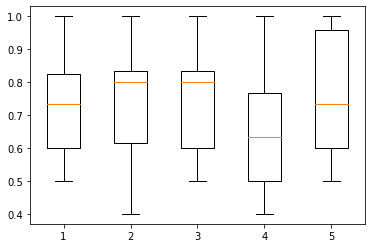

In [16]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)

for x in range(1,len(feature_names)+1):
    
    print(str(x) + ': '+  str(feature_names[x - 1]))
    
box_fig



1: perm
2: sample
3: app
4: svd
5: spectral


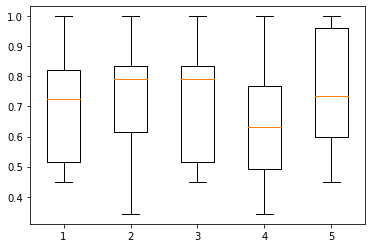

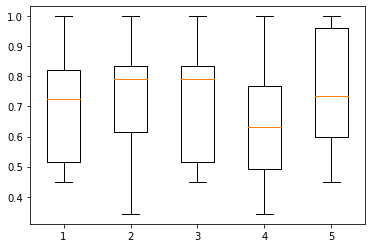

In [17]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(f1_scores)

for x in range(1,len(feature_names)+1):
    
    print(str(x) + ': '+  str(feature_names[x - 1]))
    
box_fig

### Testing for Stationarity

In [18]:
'''for X in condition:
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))'''

"for X in condition:\n    split = round(len(X) / 2)\n    X1, X2 = X[0:split], X[split:]\n    mean1, mean2 = X1.mean(), X2.mean()\n    var1, var2 = X1.var(), X2.var()\n    print('mean1=%f, mean2=%f' % (mean1, mean2))\n    print('variance1=%f, variance2=%f' % (var1, var2))"

In [19]:
from statsmodels.tsa.stattools import adfuller
mean_adf = []

'''for X in condition:
    result = adfuller(X['activity'])
    mean_adf.append(result[0])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print("adf_mean is: ")
print(np.mean(mean_adf))'''

'for X in condition:\n    result = adfuller(X[\'activity\'])\n    mean_adf.append(result[0])\n    print(\'ADF Statistic: %f\' % result[0])\n    print(\'p-value: %f\' % result[1])\n    print(\'Critical Values:\')\n    for key, value in result[4].items():\n        print(\'\t%s: %.3f\' % (key, value))\n\nprint("adf_mean is: ")\nprint(np.mean(mean_adf))'

In [20]:
'''for X in control:
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))'''

"for X in control:\n    split = round(len(X) / 2)\n    X1, X2 = X[0:split], X[split:]\n    mean1, mean2 = X1.mean(), X2.mean()\n    var1, var2 = X1.var(), X2.var()\n    print('mean1=%f, mean2=%f' % (mean1, mean2))\n    print('variance1=%f, variance2=%f' % (var1, var2))"

In [21]:
from statsmodels.tsa.stattools import adfuller
mean_adf = []

'''for X in control:
    result = adfuller(X['activity'])
    mean_adf.append(result[0])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print("adf_mean is: ")
print(np.mean(mean_adf))'''

'for X in control:\n    result = adfuller(X[\'activity\'])\n    mean_adf.append(result[0])\n    print(\'ADF Statistic: %f\' % result[0])\n    print(\'p-value: %f\' % result[1])\n    print(\'Critical Values:\')\n    for key, value in result[4].items():\n        print(\'\t%s: %.3f\' % (key, value))\n\nprint("adf_mean is: ")\nprint(np.mean(mean_adf))'

### Test for autocorrelatiom

In [22]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS


def dw(data):
    ols_res = OLS(data, np.ones(len(data))).fit()
    return durbin_watson(ols_res.resid)


In [23]:
mean_condition_dw = []
"""for X in condition:
    print(dw(X['activity']))
    mean_condition_dw.append(dw(X['activity']))
                             
print("mean is: ")
print(np.mean(mean_condition_dw))"""
                             

'for X in condition:\n    print(dw(X[\'activity\']))\n    mean_condition_dw.append(dw(X[\'activity\']))\n                             \nprint("mean is: ")\nprint(np.mean(mean_condition_dw))'

In [24]:
mean_control_dw = []
for X in control:
    print(dw(X['activity']))
    mean_control_dw.append(dw(X['activity']))
                             
print("mean is: ")
print(np.mean(mean_control_dw))
                             

0.3513942045800541
0.40461219717001534
0.4837660069660331
0.37941251737690485
0.4651657876173947
0.3621234261172371
0.43446210113951655
0.5385807365364469
0.3853743990003673
0.46394423022068404
0.41301228171125315
0.4107370906091009
0.38385470272518973
0.38509505191440624
0.5536405830944079
0.5040516730113597
0.38239235601423377
0.44155458192191327
0.4008469750625757
0.4760177365112117
0.6668685285322995
0.48001880334232
0.4015457242084993
0.5585034550416351
0.27716109027362834
0.36204393849226274
0.4829297119300984
0.304753486142385
0.3424376122636653
0.2679583171126567
0.47191565084900006
0.5178643897424546
mean is: 
0.4298137296009753


In [25]:
(-12.9 + -12.44)/2

-12.67

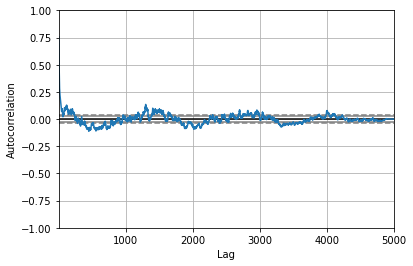

In [26]:
from pandas.plotting import autocorrelation_plot

my_plot = autocorrelation_plot(control[0]['activity'][0:5000])

plt.show()

In [27]:
import stumpy

In [28]:
control[0]['activity'].values

array([ 60,   0, 264, ...,   3,   3,   0])

In [29]:
time_series = np.array(condition[1]['activity'].values,dtype=float)
window_size = 1000 # Approximately, how many data points might be found in a pattern
matrix_profile = stumpy.stump(time_series, m=window_size)

/Users/tortysivill/.pyenv/versions/entropy_time/lib/python3.6/site-packages/stumpy/core.py:599: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10001. The TBB threading layer is disabled.
  return calculate_distance_profile(m, QT, μ_Q, σ_Q, M_T, Σ_T)


In [30]:
matrix_profile.shape

(20556, 4)

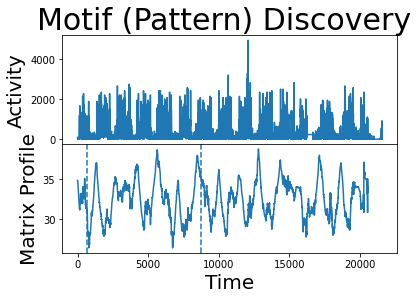

In [31]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(condition[1]['activity'].values)
axs[0].set_ylabel('Activity', fontsize='20')
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=643, linestyle="dashed")
axs[1].axvline(x=8724, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])

In [32]:
condition[0]['activity'].values.shape

(23244,)

In [33]:
matrix_profile[:,0].shape

(20556,)

In [34]:
df_matrix_profile = pd.DataFrame()
df_matrix_profile['distances']= matrix_profile[:,0]
df_matrix_profile['index'] = matrix_profile[:,1]
df_matrix_profile['index_left'] = matrix_profile[:,2]
df_matrix_profile['index_right'] = matrix_profile[:,3]

In [35]:
df_matrix_profile

,distances,index,index_left,index_right
0,34.8582,13173,-1,13173
1,34.8547,13174,-1,13174
2,34.8547,13175,-1,13175
3,34.8544,13176,-1,13176
4,34.8544,13177,-1,13177
...,...,...,...,...
20551,33.3152,16307,16307,-1
20552,33.308,16308,16308,-1
20553,33.3022,16309,16309,-1
20554,33.9605,16310,16310,-1


In [36]:
df_matrix_profile.sort_values(by='distances')

,distances,index,index_left,index_right
6730,26.3994,802,802,18088
802,26.3994,6730,547,6730
803,26.4005,6731,548,6731
6731,26.4005,803,803,18089
6729,26.4025,801,801,18087
...,...,...,...,...
12806,38.7799,2536,2536,15598
12810,38.7951,4351,4351,15602
12807,38.7961,2537,2537,15599
12808,38.8124,2538,2538,15600


In [37]:
top_motifs = df_matrix_profile.sort_values(by='distances')[0:10]
top_discords = df_matrix_profile.sort_values(by='distances')[len(df_matrix_profile)-10:len(df_matrix_profile)]

In [38]:
top_motifs

,distances,index,index_left,index_right
6730,26.3994,802,802,18088
802,26.3994,6730,547,6730
803,26.4005,6731,548,6731
6731,26.4005,803,803,18089
6729,26.4025,801,801,18087
801,26.4025,6729,546,6729
6726,26.4028,798,798,18084
798,26.4028,6726,543,6726
800,26.4065,6728,545,6728
6728,26.4065,800,800,18086


In [39]:
array = np.asarray([0,1,2,3,4,5,6,7,8,9])
windows = []
window1 = np.arange(1,1+3,1)
window2 = np.arange(2,2+3,1)
windows.append(window1)
windows.append(window2)

overall_window = set(np.concatenate(windows))

overall_window

{1, 2, 3, 4}

In [40]:
# size of time_series
time_series_size = len(condition[1])

# top 10 motifs 
top_motif_windows = []
for x in top_motifs['index']:
    window = np.arange(x,x+1000,1)
    top_motif_windows.append(window)
overall_motif_window = set(np.concatenate(top_motif_windows))
motif_size = len(overall_motif_window)
motif_probability = motif_size/time_series_size

#top 10 discords
top_discord_windows = []
for x in top_discords['index']:
    window = np.arange(x,x+1000,1)
    top_discord_windows.append(window)
overall_discord_window = set(np.concatenate(top_discord_windows))
discord_size = len(overall_discord_window)
discord_probability = discord_size/time_series_size


discord_entropy = -(discord_probability * np.log2(discord_probability))
motif_entropy = -(motif_probability * np.log2(motif_probability))


In [41]:
entropy_motif = np.sum(np.asarray([x * np.log2(x) for x in top_motifs['distances']]))
entropy_discord = np.sum(np.asarray([x * np.log2(x) for x in top_discords['distances']]))

### Extract "Motif Entropy"

In [42]:
def new_discord_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[0:10]

    #top 10 discords
    top_discord_windows = []
    for x in top_discords['index']:
        window = np.arange(x,x+1000,1)
        top_discord_windows.append(window)
    overall_discord_window = set(np.concatenate(top_discord_windows))
    discord_size = len(overall_discord_window)
    discord_probability = discord_size/time_series_size


    discord_entropy = -(discord_probability * np.log2(discord_probability))
    
    return discord_entropy
    

In [43]:
def new_motif_entropy(matrix_profile, window_size):
    # size of time_series
    time_series_size = len(matrix_profile)
    
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:10]

    # top 10 motifs 
    top_motif_windows = []
    for x in top_motifs['index']:
        window = np.arange(x,x+window_size,1)
        top_motif_windows.append(window)
    overall_motif_window = set(np.concatenate(top_motif_windows))
    motif_size = len(overall_motif_window)
    motif_probability = motif_size/time_series_size

    #top 10 discords
    top_discord_windows = []
    for x in top_discords['index']:
        window = np.arange(x,x+1000,1)
        top_discord_windows.append(window)
    overall_discord_window = set(np.concatenate(top_discord_windows))
    discord_size = len(overall_discord_window)
    discord_probability = discord_size/time_series_size

    motif_entropy = -(motif_probability * np.log2(motif_probability))
    
    return motif_entropy

In [44]:
def motif_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:100]
    entropy_motif = np.sum(np.asarray([x * np.log2(x) for x in top_motifs['distances']]))
    
    return entropy_motif

In [45]:
def discord_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    top_discords = df_matrix_profile.sort_values(by='distances')[len(df_matrix_profile)-200:len(df_matrix_profile)] 
    entropy_discord = np.sum(np.asarray([x * np.log2(x) for x in top_discords['distances']]))
    
    return entropy_discord

In [46]:
def distance_entropy(matrix_profile):
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['index'] = matrix_profile[:,1]
    df_matrix_profile['index_left'] = matrix_profile[:,2]
    df_matrix_profile['index_right'] = matrix_profile[:,3]
    
    max_discord = max(df_matrix_profile['distances'])
    entropy_distance = np.sum(np.asarray([-np.multiply((x/max_discord), np.log2(x/max_discord)).sum() for x in df_matrix_profile['distances']]))
    
    return entropy_distance

In [47]:
def calculate_matrix_profile(data, window_size):
    time_series = np.array(data, dtype=float)
    matrix_profile = stumpy.stump(time_series, m=window_size)    
    return matrix_profile

In [48]:
df_features = pd.DataFrame()
df_features['normalised_training_mean'] = normalise([np.mean(x) for x in training_data_raw])
df_features['normalised_training_std'] = normalise([np.std(x) for x in training_data_raw])

window_size = 1000
matrix_profiles = [calculate_matrix_profile(x,window_size) for x in training_data_raw]

In [49]:
df_features['new_motif_entropy'] = normalise([new_motif_entropy(x, window_size) for x in matrix_profiles])
df_features['new_discord_entropy'] = normalise([new_discord_entropy(x, window_size) for x in matrix_profiles])
df_features['motif_entropy'] = normalise([motif_entropy(x) for x in matrix_profiles])
df_features['discord_entropy'] = normalise([discord_entropy(x) for x in matrix_profiles])
#df_features['distance_entropy'] = normalise([distance_entropy(x) for x in matrix_profiles])

In [50]:
entropy_feature_combinations = []

entropy_feature_names = ['new_motif_entropy', 'new_discord_entropy', 'motif_entropy', 'discord_entropy']
# singles
entropy_feature_combinations.append(df_features.drop(['new_discord_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'motif_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'discord_entropy'],axis=1).values)
entropy_feature_combinations.append(df_features.drop(['new_motif_entropy', 'new_discord_entropy', 'motif_entropy'],axis=1).values)



In [51]:
accuracy_scores = []
f1_scores = []

for X in entropy_feature_combinations:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))
    f1_scores.append(cross_val_score(clf, X, y, cv=5, scoring='f1_weighted'))

In [52]:
np.mean(accuracy_scores)

0.6681818181818181

In [53]:
np.mean(f1_scores)

0.6596239544768957

1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


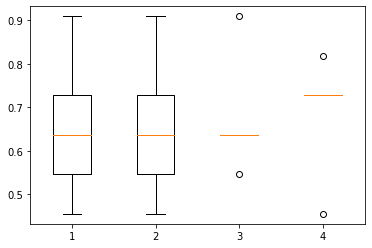

In [54]:
## Accuracy Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(accuracy_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))
    




1: new_motif_entropy
2: new_discord_entropy
3: motif_entropy
4: discord_entropy


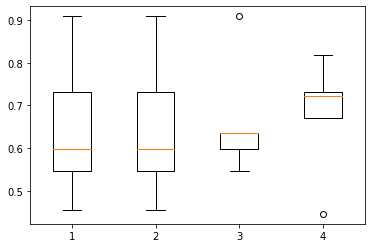

In [55]:
## F Plot
from matplotlib.pyplot import boxplot

box_plot = plt.subplots(1,1)
box_fig, box_ax = box_plot
box_ax.boxplot(f1_scores)
#box_ax.set_xticklabels(feature_names)

for x in range(1,len(entropy_feature_names)+1):
    
    print(str(x) + ': '+  str(entropy_feature_names[x - 1]))


